<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_07_pytorch_pipeline_04_imbalanced_data_SMOTEENN_ADASYN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### SMOTEENN (Synthetic Minority Over-sampling Technique and Edited Nearest Neighbors)

**SMOTEENN** is a hybrid resampling method that combines two techniques: SMOTE (Synthetic Minority Over-sampling Technique) and ENN (Edited Nearest Neighbors).

- **SMOTE**:
  - SMOTE is an oversampling technique that generates synthetic samples for the minority class (the class with fewer instances).
  - It creates new instances by interpolating between existing minority class instances. This is done by selecting two or more similar instances and creating synthetic points that lie between them.
  - The goal is to balance the class distribution by increasing the number of minority class instances.

- **ENN (Edited Nearest Neighbors)**:
  - ENN is an undersampling technique that removes instances from the dataset.
  - Specifically, it removes instances that are misclassified by their k-nearest neighbors (k-NN). The idea is to clean the dataset by removing noisy instances and outliers.
  - It helps in improving the quality of the data by ensuring that the synthetic samples generated by SMOTE are surrounded by similar instances.

**SMOTEENN** combines these two methods to balance the dataset by first generating synthetic samples for the minority class (SMOTE) and then cleaning the dataset by removing noisy instances and outliers (ENN).

### ADASYN (Adaptive Synthetic Sampling)

**ADASYN** (Adaptive Synthetic Sampling) is another oversampling technique that generates synthetic samples for the minority class. It is similar to SMOTE but with an adaptive approach.

- **Adaptive Approach**:
  - ADASYN focuses on generating more synthetic samples for minority class instances that are harder to learn (i.e., those that are closer to the decision boundary or surrounded by instances of the majority class).
  - It adaptively adjusts the number of synthetic samples to be generated based on the difficulty of learning different minority class instances.
  - This is done by giving more weight to minority class instances that are harder to classify, thereby generating more synthetic samples near these instances.

- **Goal**:
  - The goal of ADASYN is to improve the learning of the minority class by focusing on difficult-to-learn instances, thereby making the decision boundary between the classes clearer and improving the classifier's performance.

### Comparison and Usage

- **SMOTEENN** is useful when you want a combination of oversampling and undersampling to not only balance the dataset but also clean it by removing noisy instances.
- **ADASYN** is useful when you want to adaptively generate synthetic samples for the minority class, especially focusing on harder-to-learn instances, which can lead to a better-defined decision boundary.

Both methods aim to improve the performance of classifiers on imbalanced datasets by addressing the issue of class imbalance, but they do so in different ways. Choosing the right method depends on the specific characteristics of your dataset and the nature of the imbalance.

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_recall_curve
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
import torch
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data, SklearnSimpleNN, train_model


## Function Definitions

In [ ]:
# Function to convert DataFrames to tensors
def convert_to_tensors(X, y):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
    return X_tensor, y_tensor

# Function to apply SMOTEENN
def apply_smoteenn(X_train, y_train):
    smoteenn = SMOTEENN(random_state=42)
    X_train_res, y_train_res = smoteenn.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Function to apply ADASYN
def apply_adasyn(X_train, y_train):
    adasyn = ADASYN(random_state=42)
    X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Function to evaluate the model
def evaluate_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, pos_weight=1.0):
    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight)
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    y_prob = nn_estimator.model(X_test_tensor).detach().numpy().squeeze()
    return y_prob

# Function to get classification report
def get_classification_report(y_test_tensor, y_prob, threshold, resampling_method):
    y_pred = (y_prob > threshold).astype(int)
    report = classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose().reset_index()
    df_report = df_report[df_report['index'].isin(['0.0', '1.0'])]
    df_report.rename(columns={'index': 'class'}, inplace=True)
    df_report['resampling'] = resampling_method
    return df_report

def convert_report_to_dataframe(report, resampling_method):
    df_report = pd.DataFrame(report).transpose().reset_index()
    df_report['resampling'] = resampling_method
    df_report = df_report[df_report['index'].isin(['0.0', '1.0'])]
    df_report.rename(columns={'index': 'class'}, inplace=True)
    return df_report

def filter_and_rename_columns(df, metrics=['precision', 'recall', 'f1-score']):
    df = df[metrics + ['class', 'resampling']]
    return df

def combine_results(*dfs):
    df_combined = pd.concat(dfs, ignore_index=True)
    df_combined = filter_and_rename_columns(df_combined)
    df_combined.reset_index(drop=True, inplace=True)
    return df_combined

def plot_comparison(df, metrics=['precision', 'recall', 'f1-score']):
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df, x='class', y=metric, hue='resampling', palette='viridis')
        plt.title(f'Comparison of {metric.capitalize()} by Resampling Technique')
        plt.xlabel('Class')
        plt.ylabel(metric.capitalize())
        plt.legend(title='Resampling', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


### Load and Preprocess Data

In [ ]:
# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
data = load_data_from_url(url)
data = clean_column_names(data)
data = remove_id_column(data)
data = convert_categorical(data, categorical_columns=categorical_columns)
X_train, X_test, y_train, y_test = split_data(data, target=target)

# Convert test data to tensors
X_test_tensor, y_test_tensor = convert_to_tensors(X_test, y_test)


## Train and Evaluate Models (No Resampling, SMOTEENN, ADASYN)

In [ ]:
# Train model with the best class weights (3.0) without resampling
best_class_weight = 3.0
X_train_tensor, y_train_tensor = convert_to_tensors(X_train, y_train)
y_prob_no_resampling = evaluate_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, pos_weight=best_class_weight)

# Use the best lower threshold (0.10) to predict final labels
best_lower_threshold = 0.10
y_pred_no_resampling = (y_prob_no_resampling > best_lower_threshold).astype(int)

# Get classification report
report_no_resampling = classification_report(y_test_tensor.numpy(), y_pred_no_resampling, output_dict=True)
df_no_resampling = convert_report_to_dataframe(report_no_resampling, 'No Resampling')
print(f"Final Model Performance without Resampling at Best Lower Threshold {best_lower_threshold}:\n")
print(classification_report(y_test_tensor.numpy(), y_pred_no_resampling))

# Apply SMOTEENN
X_train_smoteenn, y_train_smoteenn = apply_smoteenn(X_train, y_train)
X_train_tensor_smoteenn, y_train_tensor_smoteenn = convert_to_tensors(X_train_smoteenn, y_train_smoteenn)
y_prob_smoteenn = evaluate_model(X_train_tensor_smoteenn, y_train_tensor_smoteenn, X_test_tensor, y_test_tensor, pos_weight=best_class_weight)
y_pred_smoteenn = (y_prob_smoteenn > best_lower_threshold).astype(int)
report_smoteenn = classification_report(y_test_tensor.numpy(), y_pred_smoteenn, output_dict=True)
df_smoteenn = convert_report_to_dataframe(report_smoteenn, 'SMOTEENN')
print(f"Final Model Performance with SMOTEENN at Best Lower Threshold {best_lower_threshold}:\n")
print(classification_report(y_test_tensor.numpy(), y_pred_smoteenn))

# Apply ADASYN
X_train_adasyn, y_train_adasyn = apply_adasyn(X_train, y_train)
X_train_tensor_adasyn, y_train_tensor_adasyn = convert_to_tensors(X_train_adasyn, y_train_adasyn)
y_prob_adasyn = evaluate_model(X_train_tensor_adasyn, y_train_tensor_adasyn, X_test_tensor, y_test_tensor, pos_weight=best_class_weight)
y_pred_adasyn = (y_prob_adasyn > best_lower_threshold).astype(int)
report_adasyn = classification_report(y_test_tensor.numpy(), y_pred_adasyn, output_dict=True)
df_adasyn = convert_report_to_dataframe(report_adasyn, 'ADASYN')
print(f"Final Model Performance with ADASYN at Best Lower Threshold {best_lower_threshold}:\n")
print(classification_report(y_test_tensor.numpy(), y_pred_adasyn))


Final Model Performance without Resampling at Best Lower Threshold 0.1:

              precision    recall  f1-score   support

         0.0       0.84      0.75      0.79      4673
         1.0       0.36      0.51      0.43      1327

    accuracy                           0.69      6000
   macro avg       0.60      0.63      0.61      6000
weighted avg       0.74      0.69      0.71      6000

Final Model Performance with SMOTEENN at Best Lower Threshold 0.1:

              precision    recall  f1-score   support

         0.0       0.89      0.44      0.59      4673
         1.0       0.29      0.80      0.43      1327

    accuracy                           0.52      6000
   macro avg       0.59      0.62      0.51      6000
weighted avg       0.75      0.52      0.55      6000

Final Model Performance with ADASYN at Best Lower Threshold 0.1:

              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85      4673
         1.0       0.45      0

### Combine and Save the Results

In [ ]:
# Combine results
df_combined_comparison = combine_results(df_no_resampling, df_smoteenn, df_adasyn)

# Save the combined results to a CSV file
df_combined_comparison.to_csv("resampling_comparison_results_SMOTEENN_ADASYN.csv", index=False)

### Plot the Comparison

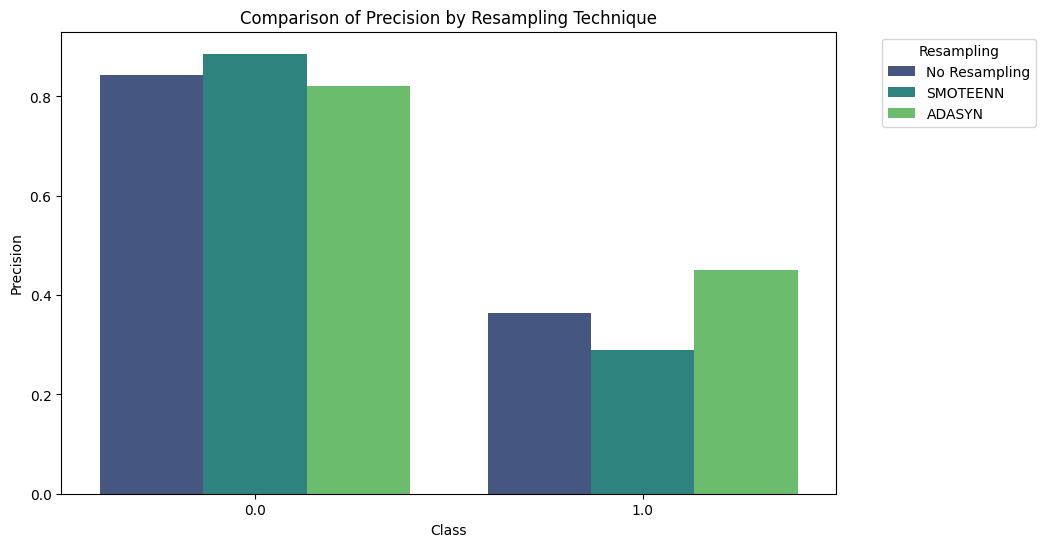

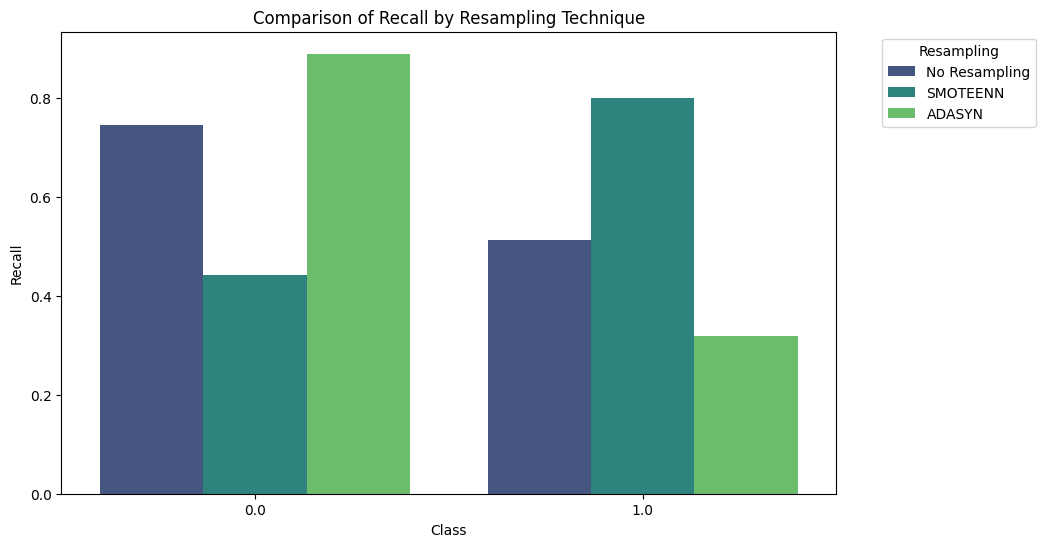

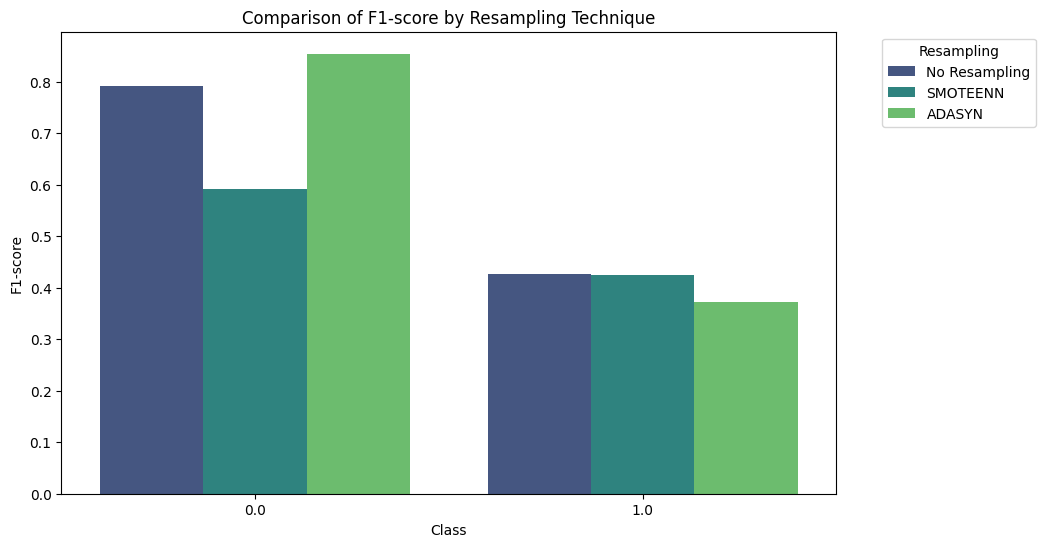

In [ ]:
# Plot precision, recall, and f1-score comparisons
plot_comparison(df_combined_comparison)


In [ ]:
df_combined_comparison

,precision,recall,f1-score,class,resampling
0,0.843697,0.746202,0.791960,0.0,No Resampling
1,0.364756,0.513188,0.426425,1.0,No Resampling
2,0.886130,0.442970,0.590669,0.0,SMOTEENN
3,0.289574,0.799548,0.425165,1.0,SMOTEENN
4,0.821252,0.889792,0.854150,0.0,ADASYN
5,0.450374,0.318011,0.372792,1.0,ADASYN


### Interpretation of SMOTEENN Results

Let's interpret the results and make recommendations based on prioritizing recall while trying to maintain a relatively high F1-score.

### Analysis and Recommendations

#### Recall Priority (Class 1)

- **No Resampling**:
  - Recall for Class 1: 0.513188
  - Precision: 0.364756
  - F1-Score: 0.426425

- **SMOTEENN**:
  - Recall for Class 1: 0.799548
  - Precision: 0.289574
  - F1-Score: 0.425165

- **ADASYN**:
  - Recall for Class 1: 0.318011
  - Precision: 0.450374
  - F1-Score: 0.372792

### Recommendation

#### **SMOTEENN**

- **Why**:
  - Highest recall for Class 1 (0.799548), which is your primary priority.
  - F1-Score for Class 1 is comparable to No Resampling (0.425165 vs. 0.426425).

- **Trade-offs**:
  - Precision for Class 1 is lower (0.289574), indicating more false positives.
  - Recall for Class 0 is lower (0.442970), meaning more false negatives in this class.

#### **No Resampling**

- **Why**:
  - Balanced recall (0.513188) and F1-Score (0.426425) for Class 1.
  - Better precision for Class 1 (0.364756) compared to SMOTEENN.

- **Trade-offs**:
  - Lower recall for Class 1 compared to SMOTEENN.
  - Balanced performance but might not meet your recall priority as strongly as SMOTEENN.

#### **ADASYN**

- **Why**:
  - High precision for Class 1 (0.450374), indicating fewer false positives.
  - High recall for Class 0 (0.889792), meaning fewer false negatives in this class.

- **Trade-offs**:
  - Lowest recall for Class 1 (0.318011), which does not meet your recall priority.
  - Lower F1-Score for Class 1 (0.372792) compared to other methods.

### Final Recommendation

Based on your priority for recall while still trying to maintain a relatively high F1-score, **SMOTEENN** is the recommended method:

1. **Highest Recall for Class 1**: 0.799548
2. **Comparable F1-Score for Class 1**: 0.425165

Although SMOTEENN has a lower precision, the recall is significantly higher, which aligns with your primary goal. Further tuning of the model and threshold can help balance these metrics better.

### Saving Report to a CSV File

In [ ]:
# Save the df_comparison DataFrame to a CSV file
df_combined_comparison.to_csv("resampling_comparison_results_SMOTEEN.csv", index=False)

#Previous SMOTE results

In [ ]:
import pandas as pd

# Data from the provided results
data_initial = {
    'class': [0.0, 1.0, 0.0, 1.0, 0.0, 1.0],
    'precision': [0.817957, 0.497981, 0.802698, 0.522727, 0.900000, 0.225129],
    'recall': [0.920180, 0.278824, 0.955061, 0.173323, 0.036593, 0.985682],
    'f1-score': [0.866062, 0.357488, 0.872276, 0.260328, 0.070327, 0.366541],
    'support': [4673.0, 1327.0, 4673.0, 1327.0, 4673.0, 1327.0],
    'resampling': ['No Resampling', 'No Resampling', 'SMOTE', 'SMOTE', 'Undersampling', 'Undersampling']
}

# Create DataFrame
df_initial_results = pd.DataFrame(data_initial)

# Save to CSV
df_initial_results.to_csv("resampling_comparison_results_SMOTE.csv", index=False)


### Combine and Compare Results

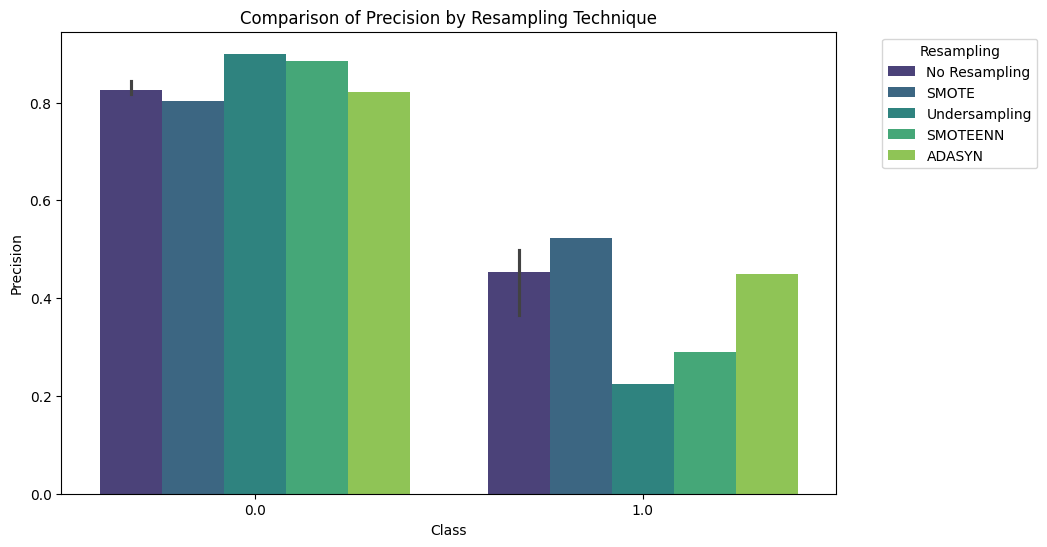

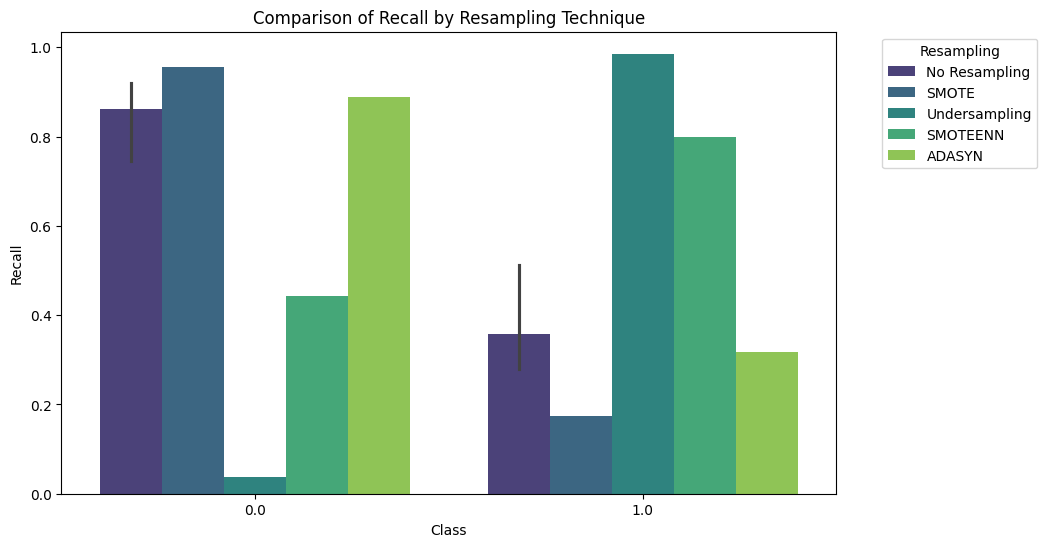

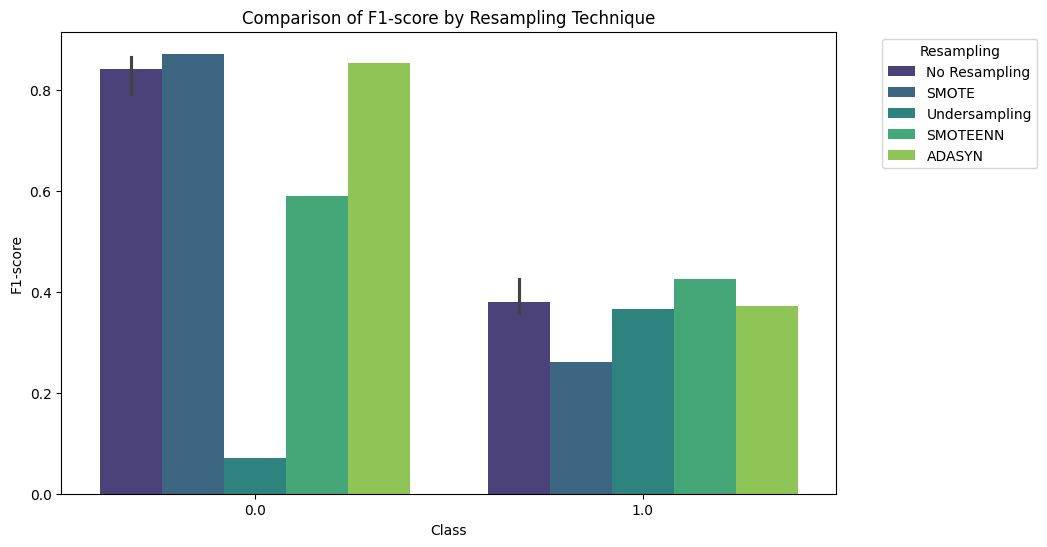

In [ ]:
# Load the previous SMOTE combined report
df_previous_smote = pd.read_csv("resampling_comparison_results_SMOTE.csv")

# Load the new SMOTEENN and ADASYN combined results
df_new_comparison = pd.read_csv("resampling_comparison_results_SMOTEEN.csv")

# Combine all results
df_combined_comparison = pd.concat([df_previous_smote, df_new_comparison], ignore_index=True)

# Plot the comparison
plot_comparison(df_combined_comparison)


In [ ]:
df_combined_comparison

,class,precision,recall,f1-score,support,resampling
0,0.0,0.817957,0.920180,0.866062,4673.0,No Resampling
1,1.0,0.497981,0.278824,0.357488,1327.0,No Resampling
2,0.0,0.802698,0.955061,0.872276,4673.0,SMOTE
3,1.0,0.522727,0.173323,0.260328,1327.0,SMOTE
4,0.0,0.900000,0.036593,0.070327,4673.0,Undersampling
5,1.0,0.225129,0.985682,0.366541,1327.0,Undersampling
6,0.0,0.817957,0.920180,0.866062,4673.0,No Resampling
7,1.0,0.497981,0.278824,0.357488,1327.0,No Resampling
8,0.0,0.802698,0.955061,0.872276,4673.0,SMOTE
9,1.0,0.522727,0.173323,0.260328,1327.0,SMOTE


### Combined Report Interpretation

### Analysis

1. **No Resampling**:
   - **Class 1** recall is higher in the recent run (0.513188) compared to the earlier runs (0.278824).
   - F1-score for Class 1 is also higher in the recent run (0.426425 vs. 0.357488).
   - Overall balanced performance but with moderate recall and F1-score for Class 1.

2. **SMOTE**:
   - **Class 1** recall is low (0.173323) in both runs.
   - F1-score for Class 1 is also low (0.260328).
   - Not ideal given your priority for recall.

3. **Undersampling**:
   - **Class 1** recall is very high (0.985682) but at the cost of extremely low precision (0.225129).
   - F1-score for Class 1 is moderate (0.366541).
   - Recall for Class 0 is extremely low (0.036593), indicating a high number of false negatives.

4. **SMOTEENN**:
   - **Class 1** recall is very high (0.799548).
   - F1-score for Class 1 is comparable to No Resampling (0.425165).
   - Precision for Class 1 is lower (0.289574), indicating more false positives.

5. **ADASYN**:
   - **Class 1** recall is lower (0.318011) compared to other methods.
   - F1-score for Class 1 is moderate (0.372792).
   - Precision for Class 1 is higher (0.450374), indicating fewer false positives.

### Recommendations

#### Based on your priority of recall while trying to maintain a relatively high F1-score:

1. **SMOTEENN**:
   - **Why**: Highest recall for Class 1 (0.799548) with a comparable F1-score (0.425165).
   - **Trade-offs**: Lower precision for Class 1 (0.289574) but the recall priority is met.

2. **No Resampling** (Recent):
   - **Why**: Balanced performance with a good recall (0.513188) and a higher F1-score (0.426425) for Class 1.
   - **Trade-offs**: Precision is moderate (0.364756) but overall balanced metrics.

3. **ADASYN**:
   - **Why**: Higher precision for Class 1 (0.450374) but lower recall (0.318011).
   - **Trade-offs**: Not meeting the recall priority as strongly as SMOTEENN.

#### Final Recommendation:

**SMOTEENN** is recommended due to the highest recall for Class 1 (0.799548) while maintaining a comparable F1-score (0.425165). This method aligns best with your priority for recall, despite the trade-off of lower precision. Further model tuning can help balance precision and recall to improve overall performance.

## Append SMOTEENN functions to resampling script

In [1]:
script_content = """
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from imbalanced_data_utils import SMOTEENN, ADASYN
from model_pipeline import SklearnSimpleNN, train_model, load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data

# Function to convert DataFrames to tensors
def convert_to_tensors(X, y):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
    return X_tensor, y_tensor

# Function to apply SMOTEENN
def apply_smoteenn(X_train, y_train):
    smoteenn = SMOTEENN(random_state=42)
    X_train_res, y_train_res = smoteenn.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Function to apply ADASYN
def apply_adasyn(X_train, y_train):
    adasyn = ADASYN(random_state=42)
    X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Function to evaluate the model
def evaluate_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, pos_weight=1.0):
    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight)
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    y_prob = nn_estimator.model(X_test_tensor).detach().numpy().squeeze()
    return y_prob

# Function to get classification report
def get_classification_report(y_test_tensor, y_prob, threshold, resampling_method):
    y_pred = (y_prob > threshold).astype(int)
    report = classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose().reset_index()
    df_report = df_report[df_report['index'].isin(['0.0', '1.0'])]
    df_report.rename(columns={'index': 'class'}, inplace=True)
    df_report['resampling'] = resampling_method
    return df_report

# Function to convert report to DataFrame
def convert_report_to_dataframe(report, resampling_method):
    df_report = pd.DataFrame(report).transpose().reset_index()
    df_report['resampling'] = resampling_method
    df_report = df_report[df_report['index'].isin(['0.0', '1.0'])]
    df_report.rename(columns={'index': 'class'}, inplace=True)
    return df_report

# Function to filter and rename columns
def filter_and_rename_columns(df, metrics=['precision', 'recall', 'f1-score']):
    df = df[metrics + ['class', 'resampling']]
    return df

# Function to combine results
def combine_results(*dfs):
    df_combined = pd.concat(dfs, ignore_index=True)
    df_combined = filter_and_rename_columns(df_combined)
    df_combined.reset_index(drop=True, inplace=True)
    return df_combined

# Function to plot comparison with a descriptive name
def plot_resampling_comparison(df, metrics=['precision', 'recall', 'f1-score']):
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df, x='class', y=metric, hue='resampling', palette='viridis')
        plt.title(f'Comparison of {metric.capitalize()} by Resampling Technique')
        plt.xlabel('Class')
        plt.ylabel(metric.capitalize())
        plt.legend(title='Resampling', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()
"""

# Append the functions to resampling_utils.py
with open("resampling_utils.py", "a") as file:
    file.write(script_content)

print("Functions appended successfully to resampling_utils.py")


Functions appended successfully to resampling_utils.py


#### Merge and Remove Duplicates

In [17]:
script_content = """
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data
from model_pipeline import SklearnSimpleNN, train_model
import torch

# Function to convert DataFrames to tensors
def convert_to_tensors(X, y):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
    return X_tensor, y_tensor

# Function to apply SMOTE
def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Function to apply SMOTEENN
def apply_smoteenn(X_train, y_train):
    smoteenn = SMOTEENN(random_state=42)
    X_train_res, y_train_res = smoteenn.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Function to apply ADASYN
def apply_adasyn(X_train, y_train):
    adasyn = ADASYN(random_state=42)
    X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Function to apply undersampling
def apply_undersampling(X_train, y_train):
    undersampler = RandomUnderSampler(random_state=42)
    X_train_res, y_train_res = undersampler.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# # Generalized function to plot class distribution after sampling
# def plot_class_distribution_after_sampling(y_train_res, sampling_type):
#     plt.figure(figsize=(8, 5))
#     sns.countplot(x=y_train_res, hue=y_train_res, palette='viridis', dodge=False, legend=False)
#     plt.title(f'Class Distribution After Applying {sampling_type}')
#     plt.xlabel('Class')
#     plt.ylabel('Count')

#     # Calculate the percentage for each class
#     total = len(y_train_res)
#     class_counts = y_train_res.value_counts()
#     for i, count in enumerate(class_counts):
#         percentage = 100 * count / total
#         plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

#     plt.show()

# Generalized function to plot class distribution after sampling
def plot_class_distribution_after_sampling(y_train_res, sampling_type):
    plt.figure(figsize=(8, 4))
    sns.countplot(x=y_train_res, hue=y_train_res, palette='viridis', dodge=False,
    order=y_train_res.value_counts().index, legend=False)
    plt.title(f'Class Distribution After Applying {sampling_type}')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Calculate the percentage for each class
    total = len(y_train_res)
    class_counts = y_train_res.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

# Function to train and evaluate the model
def train_and_evaluate_model(X_train, y_train, X_test, y_test, class_weights=None):
    input_dim = X_train.shape[1]
    if class_weights is None:
        class_weights = [1.0, 1.0]

    nn_estimator = SklearnSimpleNN(input_dim=input_dim, pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train, y_train)
    y_pred = nn_estimator.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    return report, y_pred

# Function to get classification report
def get_classification_report(y_test_tensor, y_prob, threshold, resampling_method):
    y_pred = (y_prob > threshold).astype(int)
    report = classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose().reset_index()
    df_report = df_report[df_report['index'].isin(['0.0', '1.0'])]
    df_report.rename(columns={'index': 'class'}, inplace=True)
    df_report['resampling'] = resampling_method
    return df_report

# Function to convert report to DataFrame
def convert_report_to_dataframe(report, resampling_method):
    df_report = pd.DataFrame(report).transpose().reset_index()
    df_report['resampling'] = resampling_method
    df_report = df_report[df_report['index'].isin(['0.0', '1.0'])]
    df_report.rename(columns={'index': 'class'}, inplace=True)
    return df_report

# Function to filter and rename columns
def filter_and_rename_columns(df, metrics=['precision', 'recall', 'f1-score']):
    df = df[metrics + ['class', 'resampling']]
    return df

# Function to combine results
def combine_results(*dfs):
    df_combined = pd.concat(dfs, ignore_index=True)
    df_combined = filter_and_rename_columns(df_combined)
    df_combined.reset_index(drop=True, inplace=True)
    return df_combined

# Function to plot comparison with a descriptive name
def plot_resampling_comparison(df, metrics=['precision', 'recall', 'f1-score']):
    for metric in metrics:
        plt.figure(figsize=(8, 4))
        sns.barplot(data=df, x='class', y=metric, hue='resampling', palette='viridis')
        plt.title(f'Comparison of {metric.capitalize()} by Resampling Technique')
        plt.xlabel('Class')
        plt.ylabel(metric.capitalize())
        plt.legend(title='Resampling', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

# Function to apply resampling and plot class distribution
def apply_resampling_and_plot(X_train, y_train):
    # No Resampling
    plot_class_distribution_after_sampling(y_train, "No Resampling")

    # Apply SMOTE
    X_train_smote, y_train_smote = apply_smote(X_train, y_train)
    plot_class_distribution_after_sampling(y_train_smote, "SMOTE")

    # Apply SMOTEENN
    X_train_smoteenn, y_train_smoteenn = apply_smoteenn(X_train, y_train)
    plot_class_distribution_after_sampling(y_train_smoteenn, "SMOTEENN")

    # Apply ADASYN
    X_train_adasyn, y_train_adasyn = apply_adasyn(X_train, y_train)
    plot_class_distribution_after_sampling(y_train_adasyn, "ADASYN")

    # Apply Undersampling
    X_train_under, y_train_under = apply_undersampling(X_train, y_train)
    plot_class_distribution_after_sampling(y_train_under, "Undersampling")

    return (X_train, y_train), (X_train_smote, y_train_smote), (X_train_smoteenn, y_train_smoteenn), (X_train_adasyn, y_train_adasyn), (X_train_under, y_train_under)

# Function to train and evaluate models
def train_and_evaluate_models(X_train_sets, y_train_sets, X_test, y_test):
    reports = []
    y_preds = []

    for X_train, y_train in zip(X_train_sets, y_train_sets):
        X_train_tensor, y_train_tensor = convert_to_tensors(X_train, y_train)
        X_test_tensor, y_test_tensor = convert_to_tensors(X_test, y_test)
        report, y_pred = train_and_evaluate_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)
        reports.append(report)
        y_preds.append(y_pred)

    return reports, y_preds

# # Function to gather reports and predictions into DataFrame
# def gather_reports_and_predictions(reports, y_trues, y_preds, model_names):
#     combined_report = pd.concat(
#         [pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore').assign(model=model_name) for report, model_name in zip(reports, model_names)]
#     ).reset_index().rename(columns={'index': 'class'})

#     return combined_report

# # Main function to load data and call other functions
# def run_resampling_report(url, categorical_columns, target):
#     # Load and preprocess data
#     data = load_data_from_url(url)
#     data = clean_column_names(data)
#     data = remove_id_column(data)
#     data = convert_categorical(data, categorical_columns=categorical_columns)
#     X_train, X_test, y_train, y_test = split_data(data, target=target)

#     # Apply resampling and plot class distribution
#     (X_train, y_train), (X_train_smote, y_train_smote), (X_train_smoteenn, y_train_smoteenn), (X_train_adasyn, y_train_adasyn), (X_train_under, y_train_under) = apply_resampling_and_plot(X_train, y_train)

#     # Train and evaluate models
#     X_train_sets = [X_train, X_train_smote, X_train_smoteenn, X_train_adasyn, X_train_under]
#     y_train_sets = [y_train, y_train_smote, y_train_smoteenn, y_train_adasyn, y_train_under]
#     reports, y_preds = train_and_evaluate_models(X_train_sets, y_train_sets, X_test, y_test)

#     # Gather reports and predictions
#     model_names = ['No Resampling', 'SMOTE', 'SMOTEENN', 'ADASYN', 'Undersampling']
#     combined_report = gather_reports_and_predictions(reports, [y_test]*5, y_preds, model_names)

#     # Plot multiple classification reports
#     plot_resampling_comparison(combined_report)

#     return combined_report

# Function to gather reports and predictions into DataFrame
def gather_reports_and_predictions(reports, y_trues, y_preds, model_names):
    combined_report = pd.concat(
        [pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore').assign(resampling=model_name) for report, model_name in zip(reports, model_names)]
    ).reset_index().rename(columns={'index': 'class'})

    return combined_report

# Main function to load data and call other functions
def run_resampling_report(url, categorical_columns, target):
    # Load and preprocess data
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)

    # Apply resampling and plot class distribution
    (X_train, y_train), (X_train_smote, y_train_smote), (X_train_smoteenn, y_train_smoteenn), (X_train_adasyn, y_train_adasyn), (X_train_under, y_train_under) = apply_resampling_and_plot(X_train, y_train)

    # Train and evaluate models
    X_train_sets = [X_train, X_train_smote, X_train_smoteenn, X_train_adasyn, X_train_under]
    y_train_sets = [y_train, y_train_smote, y_train_smoteenn, y_train_adasyn, y_train_under]
    reports, y_preds = train_and_evaluate_models(X_train_sets, y_train_sets, X_test, y_test)

    # Gather reports and predictions
    model_names = ['No Resampling', 'SMOTE', 'SMOTEENN', 'ADASYN', 'Undersampling']
    combined_report = gather_reports_and_predictions(reports, [y_test]*5, y_preds, model_names)

    # Plot multiple classification reports
    plot_resampling_comparison(combined_report)

    return combined_report

"""

# Append the functions to resampling_utils.py
with open("resampling_utils.py", "w") as file:
    file.write(script_content)

print("Functions written successfully to resampling_utils.py")

# reload script to make function available for use
import importlib
import resampling_utils
importlib.reload(resampling_utils)


Functions written successfully to resampling_utils.py


<module 'resampling_utils' from '/content/resampling_utils.py'>

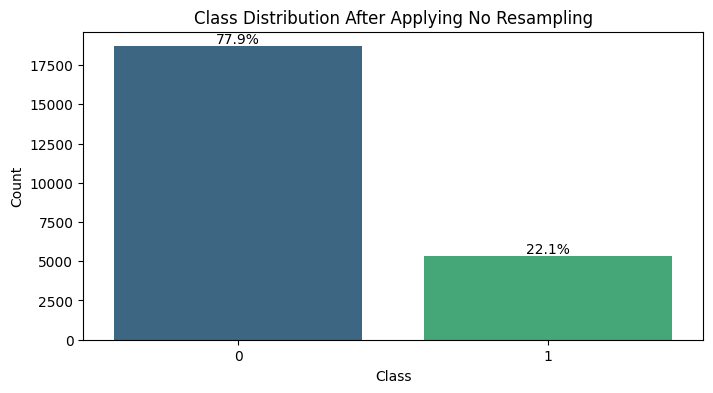

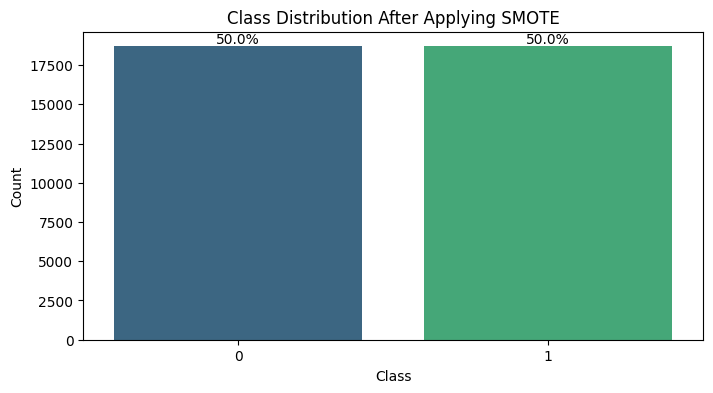

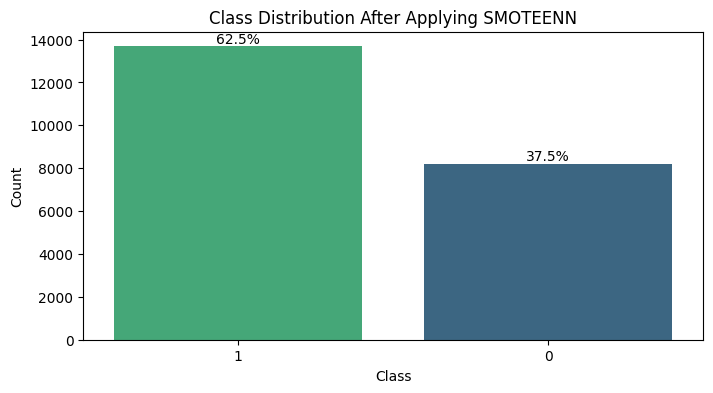

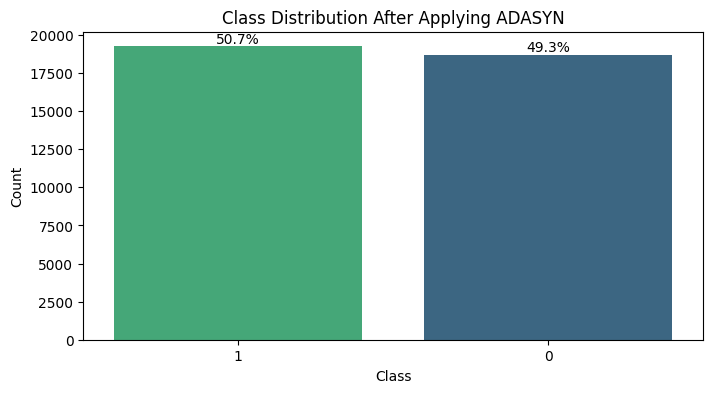

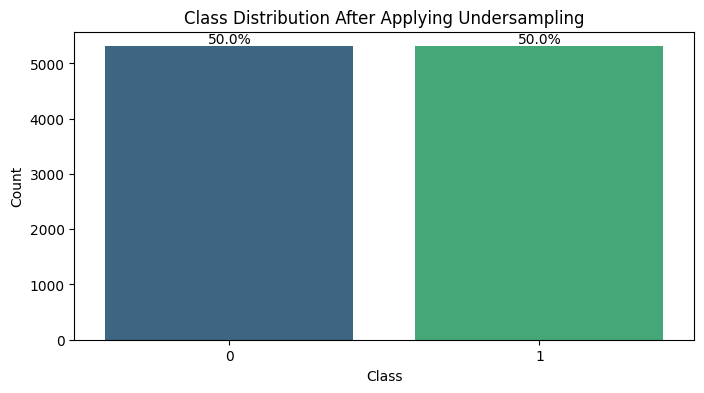

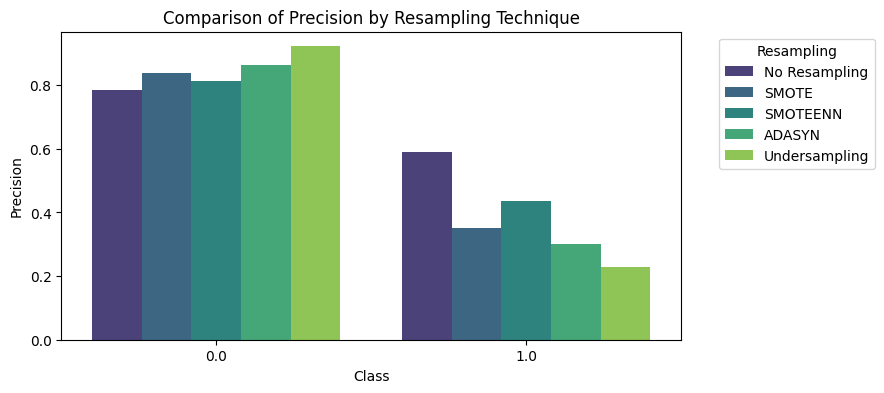

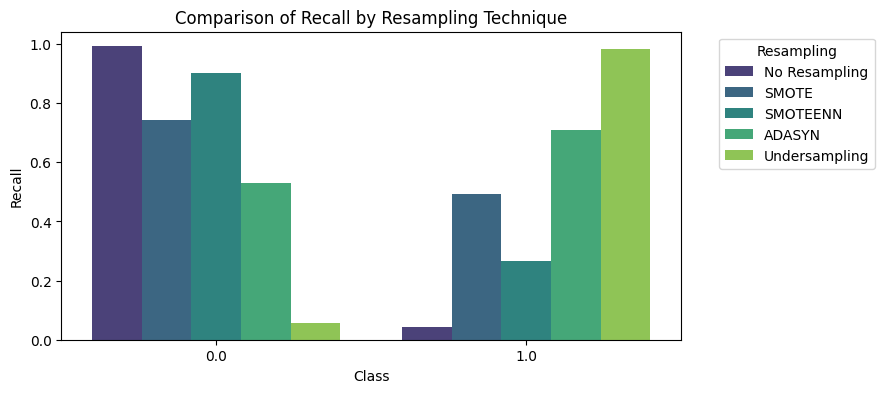

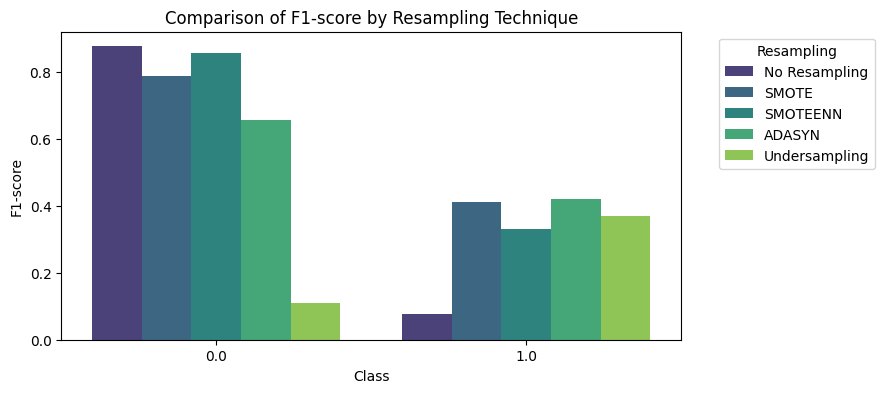

In [18]:
from resampling_utils import run_resampling_report, convert_to_tensors, plot_resampling_comparison, apply_smote, apply_smoteenn, apply_adasyn, apply_undersampling, train_and_evaluate_models, gather_reports_and_predictions

# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Run the resampling report function
combined_report = run_resampling_report(url, categorical_columns, target)
